# Auto Phase Flip Graph Coloring Oracle and Grover's Search (Two Nodes, 1 Edge)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Initialize Problem Statement

In [2]:
num_vertices = 2
edges_list = [(0, 1)]

num_edges = len(edges_list)
num_qubits = (2 * num_vertices) + num_edges + 1

possible_solutions = ["100010", "101000"]

In [3]:
print(f"Number of Vertices: {num_vertices}")
print(f"Number of Edges: {num_edges}")
print(f"Edges List: {edges_list}\n")

print(f"Number of Qubits: {num_qubits}")
print(f"Possible Solutions: {possible_solutions}")

Number of Vertices: 2
Number of Edges: 1
Edges List: [(0, 1)]

Number of Qubits: 6
Possible Solutions: ['100010', '101000']


### Visualize Graph

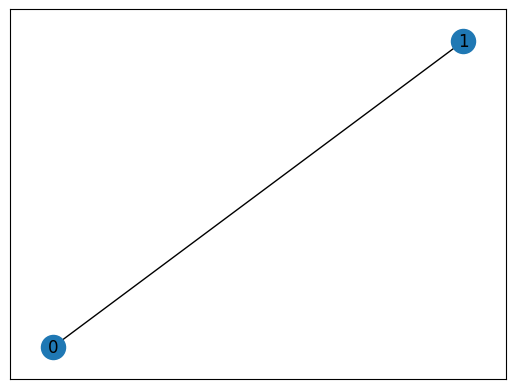

In [4]:
import networkx as nx
from networkx import Graph

def display_graph(num_vertices: int, edges_list: list[tuple[int]]) -> None:
    G = Graph()

    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges_list)

    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

display_graph(num_vertices=num_vertices, edges_list=edges_list)

## Utility Class

In [5]:
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, partial_trace, entropy
from IPython.display import display
from qiskit import QuantumCircuit, transpile
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram

import numpy as np

class Utils:

    @staticmethod
    def test_label_circuit(label: str, instruction: QuantumCircuit | Operator) -> None:
        test_vector_input = Statevector.from_label(label)
        display(test_vector_input.draw("latex", prefix="\psi_{input} = "))

        test_vector_output = test_vector_input.evolve(instruction)
        display(test_vector_output.draw("latex", prefix="\psi_{output} = O \psi_{input} = "))

        return test_vector_output

    @staticmethod
    def is_entangled(state: Statevector, epsilon: float=1e-10) -> bool:
        num_qubits = state.num_qubits
        density_matrix = DensityMatrix(state)

        for qubit in range(num_qubits):
            trace_out = [i for i in range(num_qubits) if i != qubit]
            reduced_dm = partial_trace(density_matrix, trace_out)

            subsystem_entropy = entropy(reduced_dm)

            if subsystem_entropy > epsilon:
                return True

        return False

    @staticmethod
    def simulate(circuit: QuantumCircuit, num_shots: int = 1024, display_circuit: bool = False) -> None:
        circuit.measure_all(add_bits=False)

        backend = AerSimulator()
        circuit = transpile(circuit, backend=backend)

        if display_circuit:
            display(circuit.draw("mpl"))

        counts = backend.run(circuit, shots=num_shots).result().get_counts()
        display(plot_histogram(counts, figsize=(15, 8)))

    @staticmethod
    def get_num_iter(num_qubits: int | None = None, num_states: int | None = None, num_solutions: int = None) -> int:
        if num_solutions is None:
            num_solutions = 1

        if num_states is None:
            num_states = 2 ** num_qubits

        return int(np.floor((np.pi / 4) * np.sqrt(num_states / num_solutions)))

## Auto Flip Oracle

### OR Block

In [6]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

def ORGate() -> Operator:
    circuit = QuantumCircuit(3)

    circuit.x(0)
    circuit.x(1)
    circuit.ccx(control_qubit1=0,
                control_qubit2=1,
                target_qubit=2)
    circuit.x(0)
    circuit.x(1)
    circuit.x(2)

    return Operator(circuit)

ORGate().draw("latex")

<IPython.core.display.Latex object>

#### Test OR Block

In [7]:
from IPython.display import display
from qiskit.quantum_info import Statevector

testing_states = [
    Statevector.from_label("000"),
    Statevector.from_label("010"),
    Statevector.from_label("001"),
    Statevector.from_label("011"),
]

for states in testing_states:
    display(states.evolve(ORGate()).draw("latex"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Similarity Block

In [8]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

def similarity_operator() -> Operator:
    circuit = QuantumCircuit(5)

    circuit.cx(0, 2)
    circuit.cx(1, 3)

    circuit.append(ORGate(), [2, 3, 4])

    circuit.cx(0, 2)
    circuit.cx(1, 3)

    return Operator(circuit)

similarity_operator().draw("latex")

<IPython.core.display.Latex object>

### Test Similarity Block

#### Positive Test

In [9]:
input_label = "01000"
instruction = similarity_operator()

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Negative Test

In [10]:
input_label = "00000"
instruction = similarity_operator()

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Grover's Oracle Function

In [11]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

def grover_oracle(num_qubits: int, num_vertices: int, edges_list: list[tuple[int]]) -> Operator:
    ancilla_qubits = list(range(num_vertices * 2, num_qubits - 1))

    vertices = list(range(num_vertices * 2))
    vertex_qubits = [[vertices[i], vertices[i + 1]]
                     for i in range(0, len(range(len(vertices))), 2)]

    sim_op = similarity_operator()
    circuit = QuantumCircuit(num_qubits)

    for edge_index, edge_nodes in enumerate(edges_list):
        apply_to_qubits = vertex_qubits[edge_nodes[0]] + vertex_qubits[edge_nodes[1]] + [ancilla_qubits[edge_index]]
        circuit.append(sim_op, apply_to_qubits)

    circuit.h(num_qubits - 1)
    circuit.mcx(ancilla_qubits, num_qubits - 1)
    circuit.h(num_qubits - 1)

    for edge_index, edge_nodes in enumerate(edges_list):
        apply_to_qubits = vertex_qubits[edge_nodes[0]] + vertex_qubits[edge_nodes[1]] + [ancilla_qubits[edge_index]]
        circuit.append(sim_op, apply_to_qubits)

    return Operator(circuit)

oracle_operator = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)

oracle_operator.draw("latex")

<IPython.core.display.Latex object>

### Test Oracle Operator (Single State Space)

#### Positive Test Case

In [12]:
input_label = "101000"
instruction = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Negative Test Case

In [13]:
input_label = "101010"
instruction = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Test Oracle Operator (Super-Position)

In [14]:
input_label = "+0++++"
instruction = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [15]:
import numpy as np

print("Correct Amplitude:", np.real(output_vector[int("101000", 2)]))
print("Incorrect Amplitude:", np.real(output_vector[int("101010", 2)]))

Correct Amplitude: -0.17677669529663678
Incorrect Amplitude: 0.17677669529663678


## Ristricting State Space for Number of Colors

In [16]:
from itertools import product
import numpy as np
from qiskit.quantum_info import Statevector, Operator
from qiskit import QuantumCircuit, transpile
import textwrap

def circuit_initializer(num_qubits: int, restrict_states: list[str]) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    bin_seq = ["".join(seq) for seq in product("01", repeat=num_qubits)]
    bin_seq = list(map(lambda x: textwrap.wrap(x, 2), bin_seq))

    allowed_states = [state for state in bin_seq if not any(rs in state for rs in restrict_states)]
    allowed_states = list(map(lambda x: "".join(x), allowed_states))

    amplitude = len(allowed_states)
    bin_seq = list(map(lambda x: "".join(x), bin_seq))

    state_vec_amplitudes = [1 / np.sqrt(amplitude) if state in allowed_states else 0 for state in bin_seq]
    psi_0 = Statevector(state_vec_amplitudes)

    if psi_0.is_valid():
        circuit.initialize(psi_0)

    circuit = transpile(circuit)
    circuit.data = [inst for inst in circuit.data if inst.operation.name != "reset"]

    return Operator(circuit.to_gate())

restrict_operator = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "01"])
restrict_operator.draw("latex")

<IPython.core.display.Latex object>

### Test Ristrict Operator (Base Case)

In [17]:
input_label = "0000"
instruction = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "10"])

output_vector = Utils.test_label_circuit(label=input_label, instruction=instruction)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

#### Check if the state is Entangled

In [18]:
Utils.is_entangled(state=output_vector)

False

### Test Ristrict Operator (with H Gate to Output Qubit)

In [19]:
from qiskit import QuantumCircuit

input_label = "000000"
instruction = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "10"])

circuit = QuantumCircuit(num_qubits)
circuit.append(instruction, list(range(num_vertices * 2)))
circuit.h(-1)

output_vector = Utils.test_label_circuit(label=input_label, instruction=circuit)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Test Ristrict Operator with Grover's Oracle

In [20]:
from qiskit import QuantumCircuit

input_label = "000000"
instruction_ristrict = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "10"])
instruction_oracle = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)

circuit = QuantumCircuit(num_qubits)
circuit.append(instruction_ristrict, list(range(num_vertices * 2)))
circuit.h(-1)

circuit.append(instruction_oracle, list(range(num_qubits)))

output_vector = Utils.test_label_circuit(label=input_label, instruction=circuit)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Grover's Diffusion Operator

In [21]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit

def diffusion_operator(num_vertices: int, custom_initializer: bool = False) -> Operator:
    circuit = QuantumCircuit((num_vertices * 2) + 1)

    if custom_initializer:
        restrict_operator = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "01"])
        circuit.append(restrict_operator, list(range(num_vertices * 2)))

    else:
        circuit.h(list(range(num_vertices * 2)))

    circuit.h(-1)

    vector_input = Statevector.from_instruction(circuit)
    vector_outer = np.outer(vector_input, vector_input)

    return Operator((2 * vector_outer) - np.eye(vector_outer.shape[0]))

diffusion_op = diffusion_operator(num_vertices=num_vertices)
diffusion_op.draw("latex")

<IPython.core.display.Latex object>

### Test Diffusion Operator on Random State

In [22]:
from qiskit.quantum_info import Statevector
import numpy as np

N = 5
size = 1

random_negative_idx = list(set(np.sort(np.random.randint(low=0, high=(2 ** N) - 1, size=size)).tolist()))
print(random_negative_idx)

test_vector_input = np.array(Statevector.from_label("+" * N))
test_vector_input[random_negative_idx] *= -1

test_vector_input = Statevector(test_vector_input)
test_vector_input.draw("latex")

[3]


<IPython.core.display.Latex object>

In [23]:
import numpy as np

print("Correct Amplitude:", np.real(test_vector_input[random_negative_idx[0]]))

Correct Amplitude: -0.1767766952966368


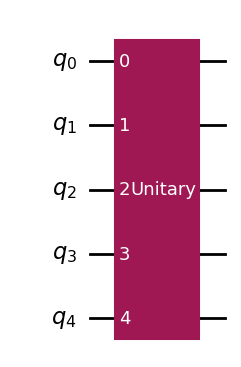

In [24]:
from qiskit import QuantumCircuit

diffusion_op = diffusion_operator(num_vertices=2)

test_circuit = QuantumCircuit(N)
test_circuit.append(diffusion_op, list(range(N)))

test_circuit.draw("mpl")

In [25]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

In [26]:
import numpy as np

print("Correct Amplitude:", np.real(test_vector_output[random_negative_idx[0]]))

Correct Amplitude: 0.5082329989778305


## Apply Grover's Search on the Problem (with all State Space, i.e., Super-Position)

### One Iteration

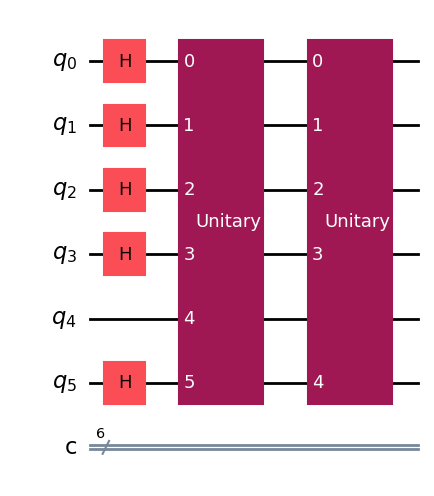

In [27]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

oracle_operator = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = diffusion_operator(num_vertices=num_vertices)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:num_vertices * 2])
circuit.h(q_regs[-1])

circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, list(range(num_vertices * 2)) + [num_qubits - 1])

circuit.draw("mpl")

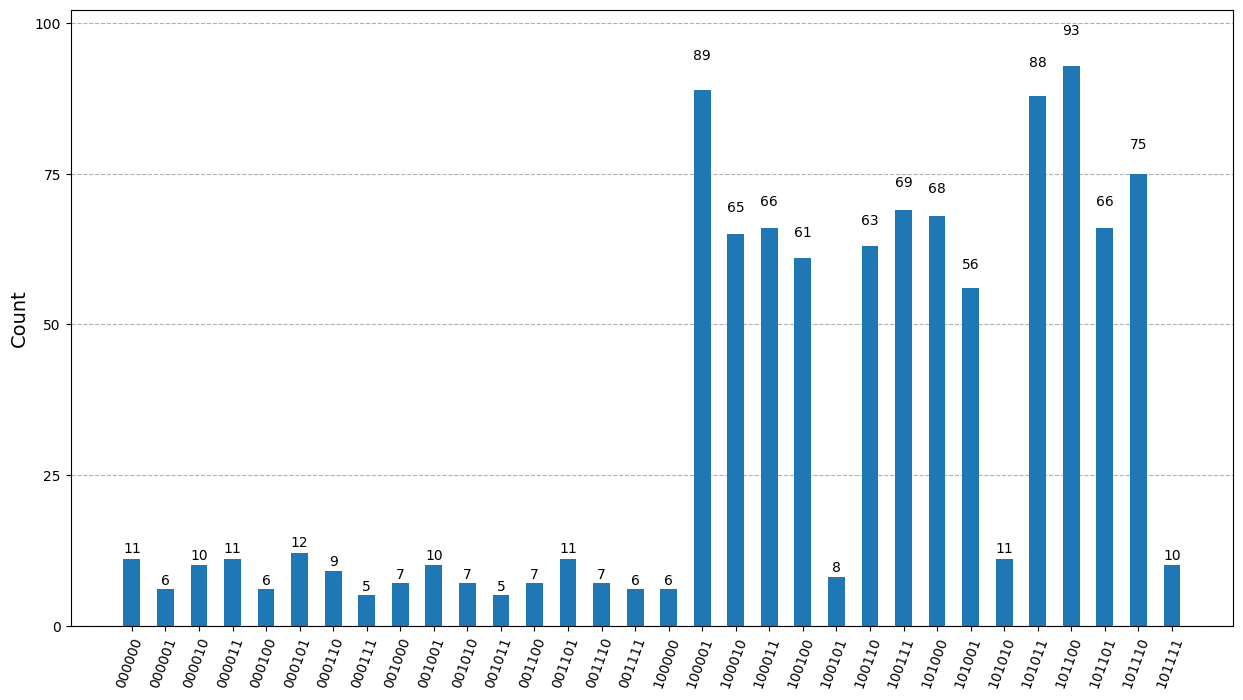

In [28]:
Utils.simulate(circuit=circuit)

### More than One Iteration

In [29]:
num_iter = Utils.get_num_iter(num_qubits=(num_qubits - 1), num_solutions=12)
print(num_iter)

1


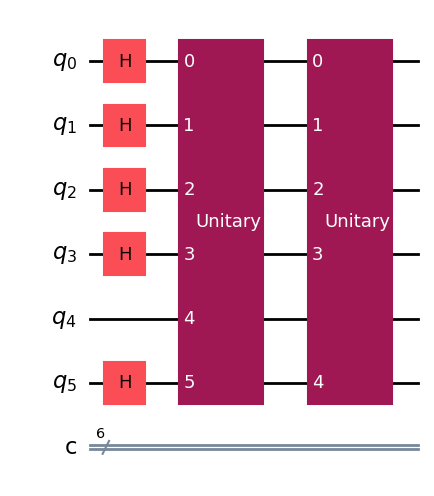

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')


oracle_operator = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = diffusion_operator(num_vertices=num_vertices)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:num_vertices * 2])
circuit.h(q_regs[-1])

for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_op, list(range(num_vertices * 2)) + [num_qubits - 1])

circuit.draw("mpl")

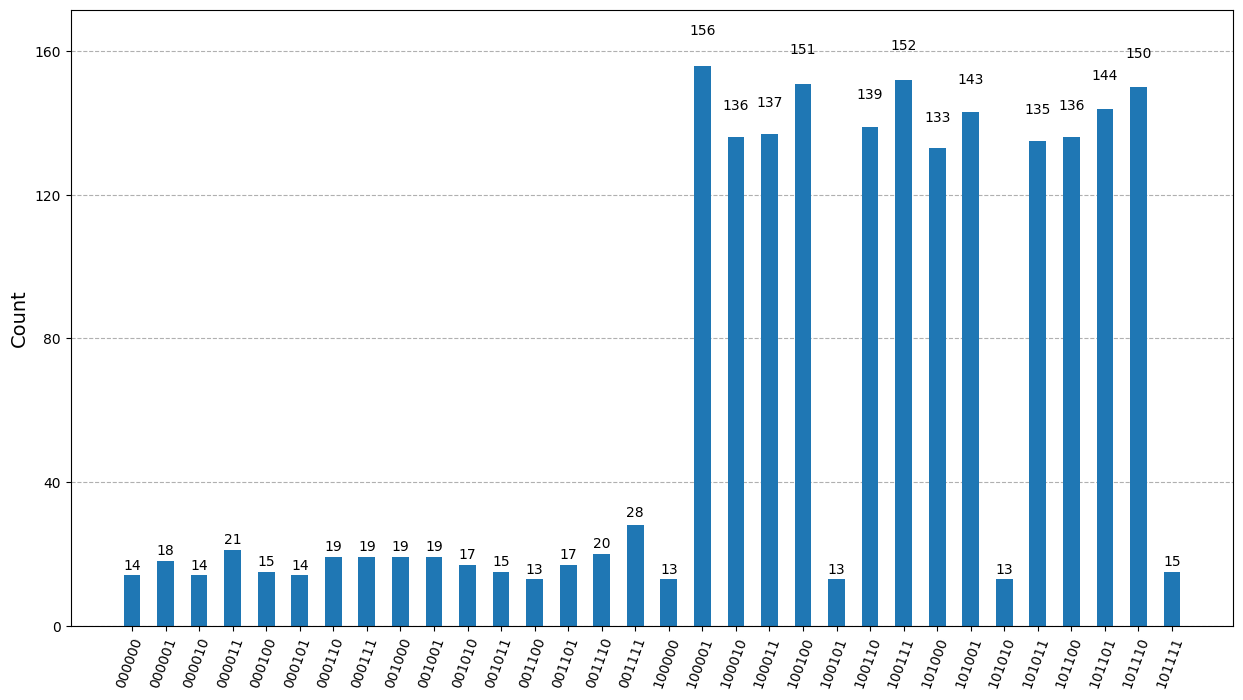

In [31]:
Utils.simulate(circuit=circuit, num_shots=(2 ** 11))

## Apply Grover's Search on the Problem (with Ristricted State Space, i.e., Only Valid Colors)

### One Iteration

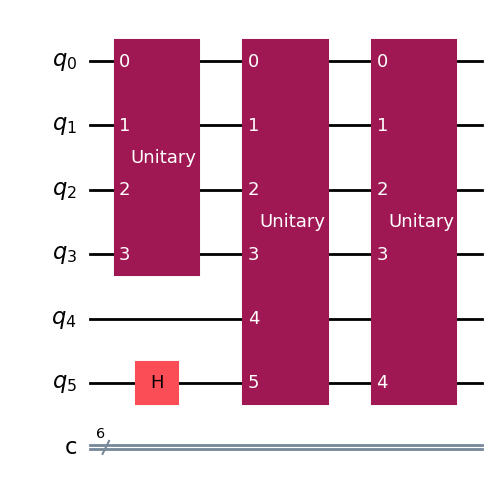

In [43]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

ristrict_operator = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "01"])
oracle_operator = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = diffusion_operator(num_vertices=num_vertices, custom_initializer=True)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.append(ristrict_operator, list(range(num_vertices * 2)))
circuit.h(q_regs[-1])

circuit.append(oracle_operator, q_regs)
circuit.append(diffusion_op, list(range(num_vertices * 2)) + [num_qubits - 1])

circuit.draw("mpl")

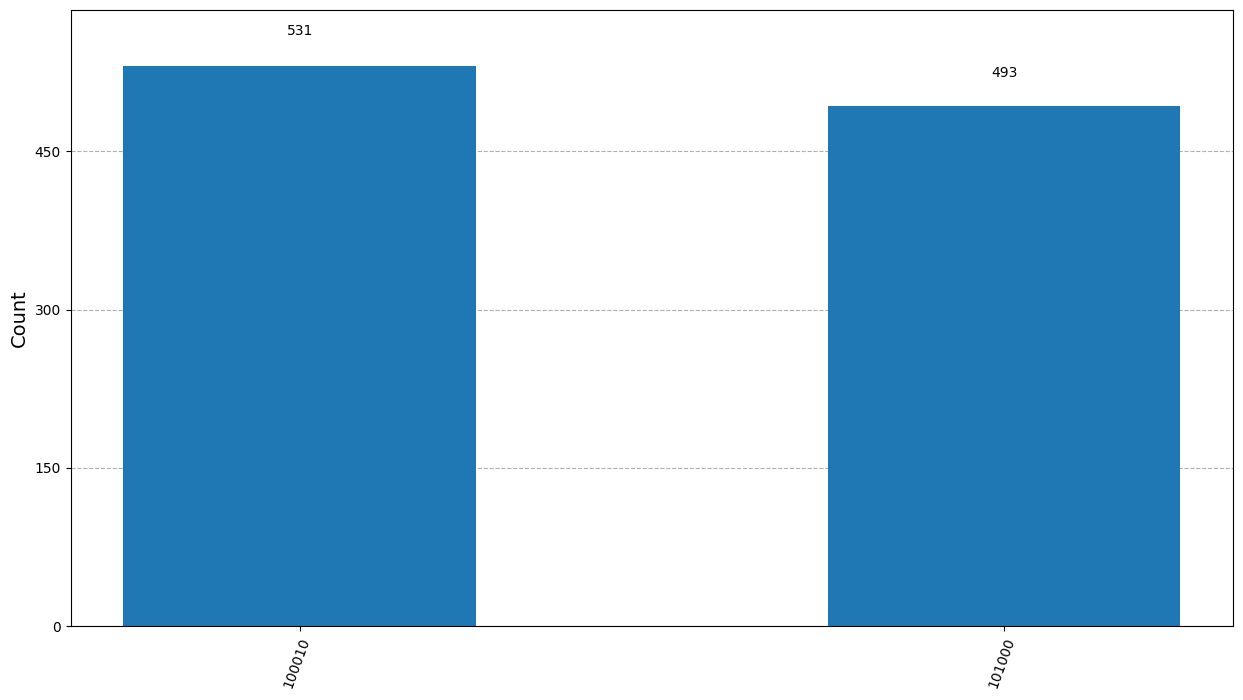

In [44]:
Utils.simulate(circuit=circuit)

### More than One Iteration

Number of Iterations: 2


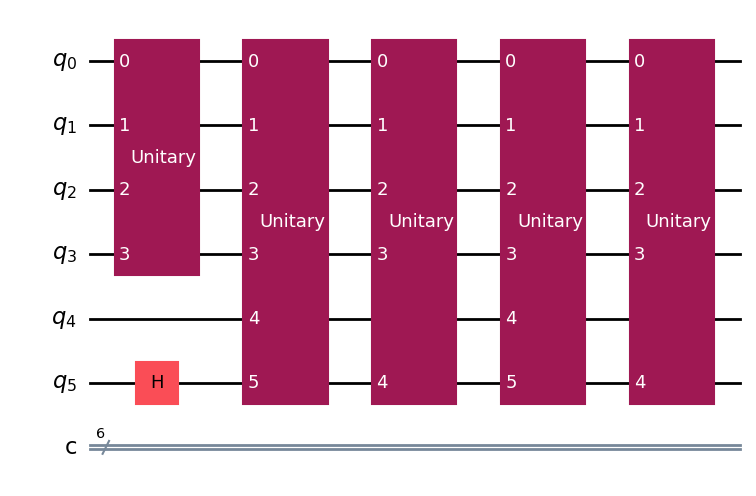

In [45]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

num_iter = Utils.get_num_iter(num_states=16, num_solutions=2)
print(f"Number of Iterations: {num_iter}")

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

ristrict_operator = circuit_initializer(num_qubits=(num_vertices * 2), restrict_states=["11", "01"])
oracle_operator = grover_oracle(num_qubits=num_qubits,
                                num_vertices=num_vertices, edges_list=edges_list)
diffusion_op = diffusion_operator(num_vertices=num_vertices, custom_initializer=True)

circuit = QuantumCircuit(q_regs, c_regs)

circuit.append(ristrict_operator, list(range(num_vertices * 2)))
circuit.h(q_regs[-1])

for _ in range(num_iter):
    circuit.append(oracle_operator, q_regs)
    circuit.append(diffusion_op, list(range(num_vertices * 2)) + [num_qubits - 1])

circuit.draw("mpl")

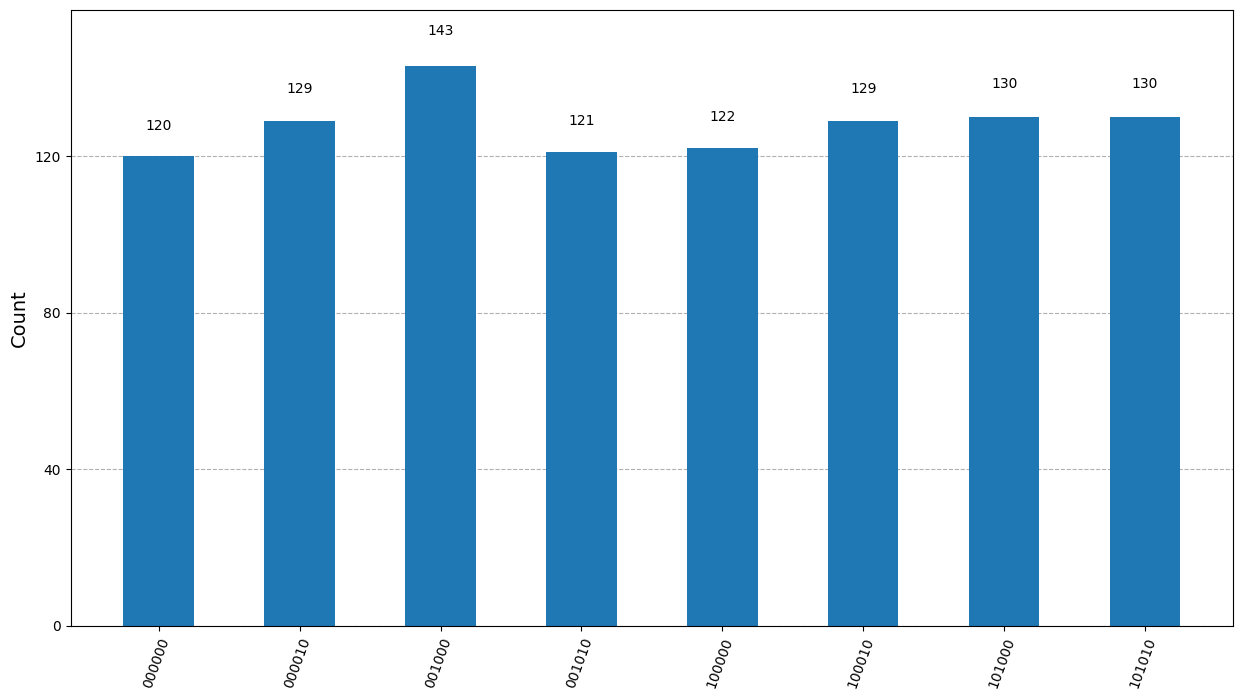

In [46]:
Utils.simulate(circuit=circuit)